# Shared Response Model

## ToDo

- [ ] create cross-validated ISC
- [ ] get transformation amtrix and project into common space
- [ ] check to see if valence and arousal come out of SRM
- [ ] check to see if timepoints -> emotion
- [ ] create threshold for emotions and check amount of time each emotion exceeds threshold

In [1]:
import numpy as np
from nltools.data import Adjacency
import pandas as pd
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.style
import matplotlib as mpl
mpl.style.use('bmh')

from nltools.stats import align
import seaborn as sns
from scipy.stats import zscore

//anaconda2/envs/py3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
emotions = ['Afraid', 'Amused', 'Angry', 'Anxious', 'Bored', 'Disgusted',
       'Frustrated', 'Happy', 'Hopeful', 'Inspired', 'Moved', 'Proud',
       'Relieved', 'Sad', 'Surprised', 'Uncomfortable']

emotionColors = {
'Amused'  : (0.99,0.01,0.01),
'Happy'  : (0.99,0.25,0.01),
'Surprised'  : (0.99,0.44,0.01),
'Relieved'  : (0.99,0.75,0.01),
'Hopeful'  : (0.99,0.99,0.01),
'Inspired'  : (0.6,0.99,0.01),
'Proud'  : (0.01,0.99,0.56),
'Moved'  : (0.01,0.99,0.89),
'Sad'  : (0.01,0.79,0.99),
'Afraid'  : (0.01,0.44,0.99),
'Anxious'  : (0.22,0.01,0.99),
'Uncomfortable'  : (0.68,0.01,0.99),
'Angry'  : (0.99,0.01,0.91),
'Frustrated'  : (0.99,0.01,0.4),
'Disgusted' : 'brown',
'Bored' : 'gray'}


In [3]:
# Getting NAN error so dropping all NA's for now
# (will only have scan data and a few mturk participants)
p_emo_summary = pd.DataFrame()

for emo in emotions: 
    df = pd.DataFrame()

    for stim in [1,2,3,4,5,6,7,9]: 
        df_add = pd.read_csv('../MothBehavioralAnalysis/out/cf_predictions/stim-%s_emo-%s_dilation-30.csv' % (stim, emo), index_col=0)
#         df_add = df_add.sub(df_add.mean(axis=1), axis=0) #Demean data
        df = pd.concat([df, df_add], axis=1, sort=False) #Concat
        
    df.dropna(inplace=True)
    df.iloc[:,:] = zscore(df, axis=1) # Z score data using all videos

    p_emo_summary = p_emo_summary.append(df)


In [4]:
# Copied Code From Luke's SRM on dartbrains (?)

data = []
for participant in list(set(p_emo_summary.index.values)): 
    p = p_emo_summary.loc[participant,:]
    p.index = emotions
    data.append(p.to_numpy())
    
n_features = 16
out = align(data, method='probabilistic_srm', n_features=n_features)

original_data = [np.dot(t.T,tm.T) for t,tm in zip(out['transformed'],out['transformation_matrix'])]

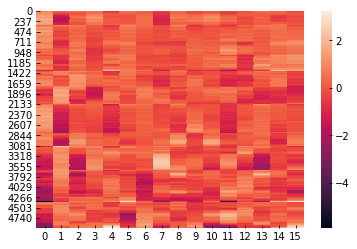

In [6]:
sns.heatmap(out['common_model'].T)

In [7]:
out = align(data, method='probabilistic_srm', n_features=n_features)


## Calculate the average loading of each feeling onto shared componenets

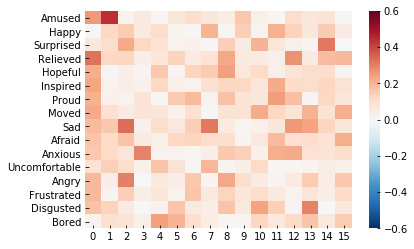

In [8]:
t_matrices = pd.DataFrame(np.mean(out['transformation_matrix'], axis=0))
t_matrices.index = emotions
t_matrices = t_matrices.reindex(emotionColors.keys())
sns.heatmap(np.abs(t_matrices), cmap='RdBu_r', vmin=-.6, vmax=.6)

## Calculate the similarity of feeling weights in each component

In [9]:
# component_means = []

# for c in range(16):

#     weights = pd.DataFrame()

#     for p in range(len(out['transformation_matrix'])): 
#         weights = pd.concat([weights,pd.DataFrame(out['transformation_matrix'][p][c])], axis=1)

#     dist = Adjacency(pairwise_distances(weights.T, metric='correlation'), matrix_type='distance')
#     sim = dist.distance_to_similarity()
#     f = sim.plot(cmap='RdBu_r', vmin=0, vmax=1)
#     component_means.append(sim.mean())


In [10]:
# plt.scatter(range(len(component_means)), component_means)
# plt.ylim(0,1)
# plt.title('Component Similarity Means')

NameError: name 'component_means' is not defined

In [ ]:
# np.array(component_means).std()

In [ ]:
# plt.scatter(range(0,16),sorted(list(out['isc'].values()), reverse=True))
# plt.title("ISC of Latent Components")
# plt.xlabel("Component")
# plt.ylabel("ISC")

In [ ]:
# sorted(list(out['isc'].values()), reverse=True)

## SRM Transformations

In [11]:
import itertools

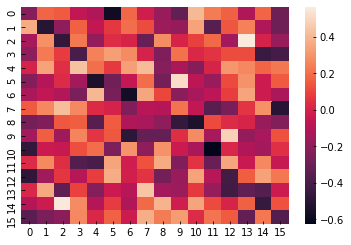

In [12]:
sns.heatmap(out['transformation_matrix'][1])

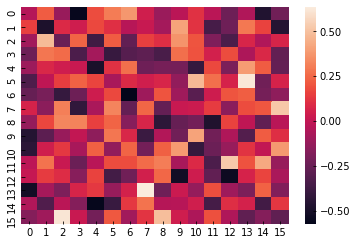

In [13]:
sns.heatmap(out['transformation_matrix'][0])

In [14]:
t_matrix = out['transformation_matrix']
m_summary = np.zeros((72,72))

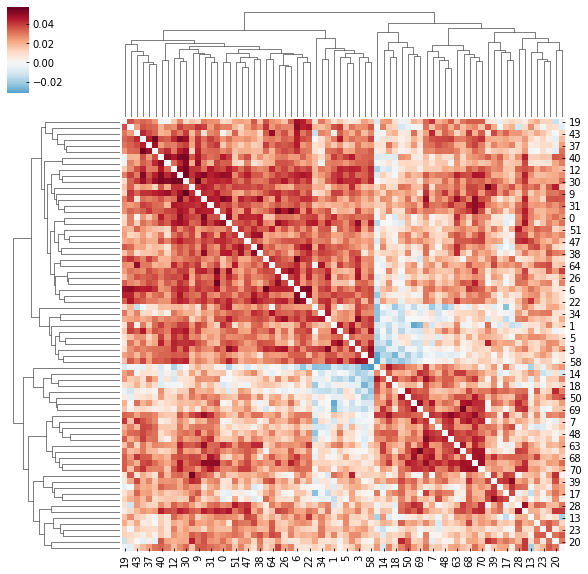

In [34]:
combos = list(itertools.combinations(range(72),2))
m_summary_correlation = np.zeros((72,72))

for combo in combos: 
    try: 
        dist = 1 - pairwise_distances(t_matrix[combo[0]], t_matrix[combo[1]], metric='correlation')
        # Cast distance into adjacency Ajdacency(dist, 'correlation')
        # Can past in list of labels
        # Plot mds
        # Mean pulls lower triangle
        
        
#         dist = pairwise_distances(t_matrix[combo[0]], t_matrix[combo[1]], metric='euclidian')
        m_summary_correlation[combo[0],combo[1]] = dist.mean()
        m_summary_correlation[combo[1],combo[0]] = dist.mean()

    except:
        pass
    
sns.clustermap(pd.DataFrame(m_summary_correlation), center=0, cmap='RdBu_r')

# Cosine Similarity Adjacency Corr Matrix Using Luke's Code

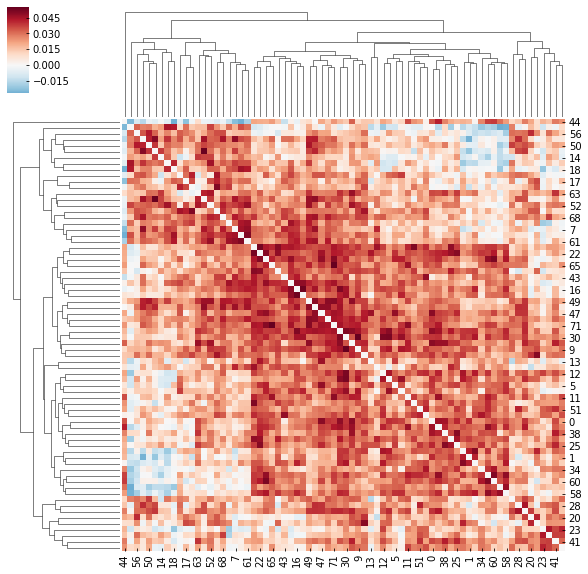

In [37]:
combos = list(itertools.combinations(range(72),2))
m_summary_cosine = np.zeros((72,72))
for combo in combos: 
    try: 
        dist = cosine_similarity(t_matrix[combo[0]], t_matrix[combo[1]])

        m_summary_cosine[combo[0],combo[1]] = dist.mean()
        m_summary_cosine[combo[1],combo[0]] = dist.mean()

    except:
        pass
    
sns.heatmap(pd.DataFrame(m_summary_cosine), center=0, cmap='RdBu_r')

//anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


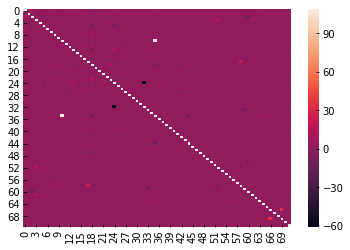

In [32]:
# Cosine - Correlation

sns.heatmap(m_summary_cosine/m_summary_correlation)